Total clips for userId=6: 297
Categories: ['การออกกำลังกาย' 'สปอย' 'พอดแคสต์พัฒนาตนเอง' 'สารคดี' 'ข่าว']


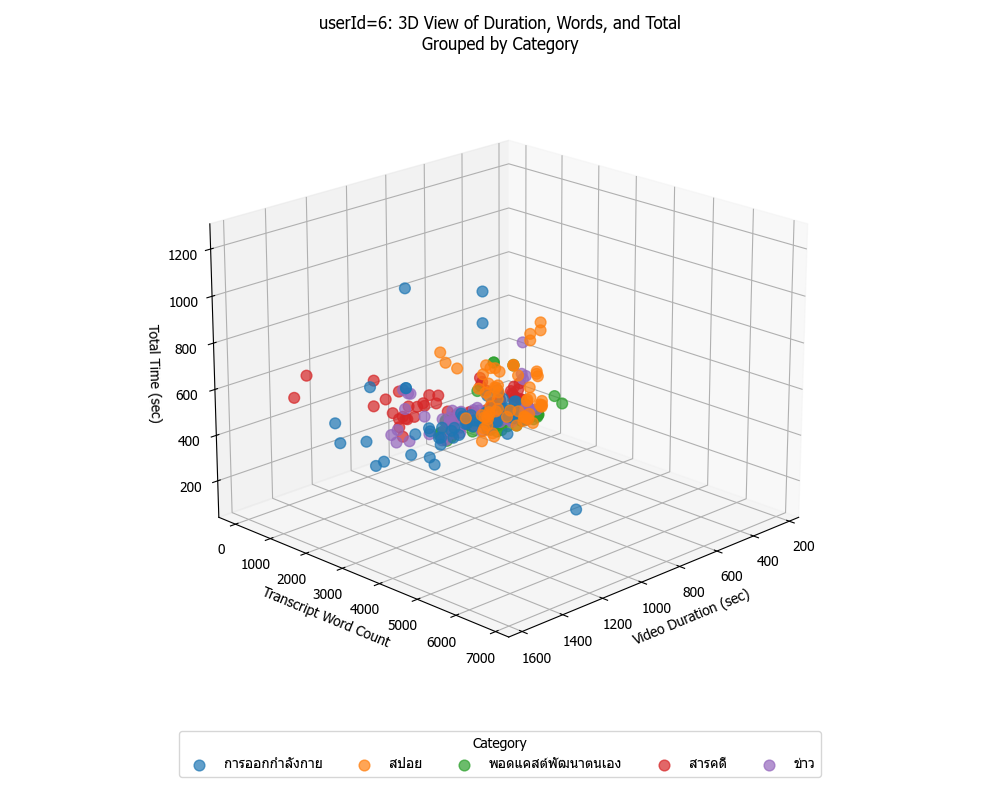

In [6]:
%matplotlib widget
# =========================
# ANALYSIS: userId = 6
# 3D Scatter Plot: transcriptWord, durationSec, timeTotal
# =========================
import pandas as pd
import matplotlib.pyplot as plt
import re
from mpl_toolkits.mplot3d import Axes3D

# ตั้งค่าฟอนต์ภาษาไทย
plt.rcParams['font.family'] = 'Tahoma'

# --- Load Data ---
stats_df = pd.read_csv('stats_data.csv')
mapper_df = pd.read_excel('75clip_mapper.xlsx')

userId = 6

# --- Filter userId = 6 and status = DONE ---
df_user6 = stats_df[(stats_df['userId'] == userId) & (stats_df['status'] == 'DONE')].copy()

# --- Normalize YouTube URL for joining ---
def normalize_url(url):
    if pd.isna(url):
        return None
    patterns = [
        r'(?:v=|youtu\.be/)([a-zA-Z0-9_-]{11})',
        r'(?:embed/)([a-zA-Z0-9_-]{11})',
        r'(?:shorts/)([a-zA-Z0-9_-]{11})'
    ]
    for pattern in patterns:
        match = re.search(pattern, str(url))
        if match:
            return match.group(1)
    return None

df_user6['video_id'] = df_user6['youtubeUrl'].apply(normalize_url)
mapper_df['video_id'] = mapper_df['YoutubeUrl'].apply(normalize_url)

# --- Merge with mapper ---
df_merged = df_user6.merge(
    mapper_df[['video_id', 'Category', 'Duration(min)']],
    on='video_id',
    how='left'
)

# --- Filter valid data ---
df_merged = df_merged.dropna(subset=['transcriptWord', 'durationSec', 'timeTotal', 'Category'])

print(f'Total clips for userId=6: {len(df_merged)}')
print(f'Categories: {df_merged["Category"].unique()}')

# =========================
# 3D SCATTER PLOT (แก้ไขแล้ว)
# =========================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

categories = df_merged['Category'].unique()
colors = plt.cm.tab10(range(len(categories)))

for i, cat in enumerate(categories):
    subset = df_merged[df_merged['Category'] == cat]
    ax.scatter(
        subset['durationSec'],
        subset['transcriptWord'],
        subset['timeTotal'],
        c=[colors[i]],
        label=cat,
        alpha=0.7,
        s=60
    )

ax.set_xlabel('Video Duration (sec)')
ax.set_ylabel('Transcript Word Count')
ax.set_zlabel('Total Time (sec)')
ax.set_title('userId=6: 3D View of Duration, Words, and Total\nGrouped by Category')

# ย้าย legend ออกไปด้านล่าง
fig.legend(title='Category', loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0.02))

# ปรับมุมมองให้เห็นแกน z ชัดขึ้น
ax.view_init(elev=20, azim=45)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # เว้นที่ด้านล่างสำหรับ legend
plt.show()

In [4]:
import plotly.express as px

# สร้าง 2D Scatter Plot แบบ interactive
fig = px.scatter(
    df_merged,
    x='durationSec',
    y='timeTotal',
    color='Category',
    hover_data=['transcriptWord', 'whisperTemp', 'youtubeUrl'],  # เพิ่ม whisperTemp
    title='userId=6: Video Duration vs Total Time<br>(Hover to see Transcript Word Count)',
    labels={
        'durationSec': 'ความยาวคลิป (sec)',
        'timeTotal': 'เวลาที่ใช้สรุปทั้งหมด (sec)',
        'transcriptWord': 'จำนวนคำ',
        'whisperTemp': 'Whisper Temp'  
    }
)

# ปรับขนาดและ style
fig.update_traces(marker=dict(size=10, opacity=0.7))
fig.update_layout(
    width=900,
    height=600,
    legend_title_text='Category',
    hovermode='closest'
)

fig.show()

### filter by category, whisperTemp, duration (100group) อยากรู้ว่า ยิ่ง transcript word มาก มันส่งผลต่อ total time ไหม

In [ ]:
คิด trend โดย sort x เช่น(1, 3, 5) แล้วดูว่า ค่า มีส่วนต่าง(y2 - y1, y3 - y2)เท่าไร ถ้าเป็น + คู่ = increadsing 
ถ้าเป็น - คู่ = decreasing

In [17]:
df_merged["duration_group"] = (df_merged["durationSec"] / 300).round() * 300
import numpy as np

def trend_direction(x, y):
    # x = transcriptWord, y = totalTime
    order = np.argsort(x)
    y_sorted = y[order]

    if np.all(np.diff(y_sorted) > 0):
        return "increasing"
    elif np.all(np.diff(y_sorted) < 0):
        return "decreasing"
    else:
        return "mixed"

results = []

group_cols = ["Category", "whisperTemp", "duration_group"]

for keys, g in df_merged.groupby(group_cols):
    if len(g) == 3:
        trend = trend_direction(
            g["transcriptWord"].values,
            g["timeTotal"].values
        )
        results.append({
            "Category": keys[0],
            "Temp": keys[1],
            "Duration": keys[2],
            "trend": trend
        })

import pandas as pd

trend_df = pd.DataFrame(results)

trend_df.groupby(["Category", "Temp"])["trend"].value_counts(normalize=True)

import plotly.express as px

summary = (
    trend_df
    .assign(is_increasing=lambda x: x["trend"] == "increasing")
    .groupby(["Category", "Temp"])["is_increasing"]
    .mean()
    .reset_index()
)

fig = px.imshow(
    summary.pivot(
        index="Category",
        columns="Temp",
        values="is_increasing"
    ),
    title="Proportion of Groups Showing Increasing Total Time<br>with Transcript Word Count"
)

fig.show()

ผล: word มาก ส่งผลให้เวลาเพิ่มจะเป็นจริงแค่ พอสแคสต์ แต่ category พบว่าไม่จำเป็นเสมอไป หรือไม่ก็ ข้อมูลไม่เพียงพอ

### งั้นลองเปลี่ยนจาก total time -> speech to text time

In [8]:
# 1) สร้าง duration group (5,10,15,20,25 นาที)
df_merged["duration_group"] = (df_merged["durationSec"] / 300).round() * 300

import numpy as np

# 2) ฟังก์ชันดูแนวโน้ม (เหมือนเดิม)
def trend_direction(x, y):
    # x = transcriptWord, y = timeSpeechtoTextSec
    order = np.argsort(x)
    y_sorted = y[order]

    if np.all(np.diff(y_sorted) > 0):
        return "increasing"
    elif np.all(np.diff(y_sorted) < 0):
        return "decreasing"
    else:
        return "mixed"

# 3) คำนวณ trend ต่อ group
results = []

group_cols = ["Category", "whisperTemp", "duration_group"]

for keys, g in df_merged.groupby(group_cols):
    # ต้องมีครบ 3 ตัว และ STT time ไม่เป็น NaN
    if len(g) == 3 and g["timeSpeechtoTextSec"].notna().all():
        trend = trend_direction(
            g["transcriptWord"].values,
            g["timeSpeechtoTextSec"].values
        )
        results.append({
            "Category": keys[0],
            "Temp": keys[1],
            "Duration": keys[2],
            "trend": trend
        })

import pandas as pd

trend_df = pd.DataFrame(results)

# 4) ดูสัดส่วน trend (optional debug)
trend_df.groupby(["Category", "Temp"])["trend"].value_counts(normalize=True)
import plotly.express as px

summary = (
    trend_df
    .assign(is_increasing=lambda x: x["trend"] == "increasing")
    .groupby(["Category", "Temp"])["is_increasing"]
    .mean()
    .reset_index()
)

fig = px.imshow(
    summary.pivot(
        index="Category",
        columns="Temp",
        values="is_increasing"
    ),
    title="Proportion of Groups Showing Increasing STT Time<br>with Transcript Word Count"
)

fig.show()


ผล: มีแนวโน้มว่า ยิ่ง transcriptWord มากขึ้น ยิ่ง timeSpeechtoTextSec มากขึ้นตาม ในหลายกลุ่ม

### whisper temp มากๆ มันทำให้สรุปเร็วขึ้นหรอ

In [9]:
from scipy.stats import spearmanr

results = []

for (cat, dur), g in df_merged.groupby(["Category", "duration_group"]):
    if g["whisperTemp"].nunique() >= 3:
        rho, _ = spearmanr(
            g["whisperTemp"],
            g["timeTotal"]
        )
        results.append({
            "Category": cat,
            "Duration": dur,
            "rho": rho
        })

rho_df = pd.DataFrame(results)


In [10]:
summary = (
    rho_df
    .assign(is_faster=lambda x: x["rho"] < 0)
    .groupby("Category")["is_faster"]
    .mean()
)

print(summary)

Category
การออกกำลังกาย        1.0
ข่าว                  0.8
พอดแคสต์พัฒนาตนเอง    0.8
สปอย                  0.8
สารคดี                0.8
Name: is_faster, dtype: float64


ใน Category = การออกกำลังกาย 100% ของ duration เมื่อ whisperTemp เพิ่มขึ้น → total time มีแนวโน้ม “ลดลง”
ใน Category อื่น ๆ 80% ของ duration มีแนวโน้มไปทาง “เร็วขึ้น”

In [61]:
df = df_merged.copy()

# duration group (± 5 นาที)
df["duration_group"] = (
    df["durationSec"] / 300
).round().astype(int) * 300

# normalize time
df["time_per_1k_word"] = (
    df["timeTotal"] / df["transcriptWord"] * 1000
)


In [62]:
from scipy.stats import spearmanr

results_norm = []

for (cat, dur), g in df.groupby(["Category", "duration_group"]):
    if g["whisperTemp"].nunique() >= 3:
        rho, _ = spearmanr(
            g["whisperTemp"],
            g["time_per_1k_word"]
        )
        results_norm.append({
            "Category": cat,
            "Duration": dur,
            "rho_norm": rho
        })

rho_norm_df = pd.DataFrame(results_norm)

summary_norm = (
    rho_norm_df
    .assign(is_faster=lambda x: x["rho_norm"] < 0)
    .groupby("Category")["is_faster"]
    .mean()
)

print(summary_norm)


Category
การออกกำลังกาย        0.4
ข่าว                  1.0
พอดแคสต์พัฒนาตนเอง    0.8
สปอย                  0.8
สารคดี                1.0
Name: is_faster, dtype: float64


ข่าว, สารคดี
→ whisperTemp สูง ทำให้ประมวลผลเร็วขึ้นจริง (ทุก duration)
พอดแคสต์พัฒนาตนเอง, สปอย
→ ส่วนใหญ่เร็วขึ้น แต่ไม่สม่ำเสมอทุก duration
การออกกำลังกาย
→ ไม่พบผลชัดเจน

แต่ด้านบนมันคิดเทียบกับ time total ซึ่งจริงๆควรเทียบกับ timeSpeechtoTextSec

In [64]:
import pandas as pd
import numpy as np

df = df_merged.copy()

# จัดกลุ่ม duration (≈ 5,10,15,20,25 นาที)
df["duration_group"] = (
    df["durationSec"] / 300
).round().astype(int) * 300

# normalize: เวลา STT ต่อ 1,000 คำ
df["stt_time_per_1k_word"] = (
    df["timeSpeechtoTextSec"] / df["transcriptWord"] * 1000
)


In [67]:
from scipy.stats import spearmanr

results_norm = []

for (cat, dur), g in df.groupby(["Category", "duration_group"]):
    if g["whisperTemp"].nunique() >= 3:
        rho, _ = spearmanr(
            g["whisperTemp"],
            g["stt_time_per_1k_word"]
        )
        results_norm.append({
            "Category": cat,
            "Duration": dur,
            "rho_norm": rho
        })

rho_norm_df = pd.DataFrame(results_norm)
summary_norm = (
    rho_norm_df
    .assign(is_faster=lambda x: x["rho_norm"] < 0)
    .groupby("Category")["is_faster"]
    .mean()
)

print(summary_norm)

Category
การออกกำลังกาย        0.4
ข่าว                  1.0
พอดแคสต์พัฒนาตนเอง    1.0
สปอย                  0.6
สารคดี                0.8
Name: is_faster, dtype: float64


ข่าว, พอดแคสต์พัฒนาตนเอง → whisperTemp สูง ทำให้ Speech-to-Text เร็วขึ้นจริง (สม่ำเสมอทุก duration)
สารคดี → ส่วนใหญ่เร็วขึ้น แต่ไม่ครบทุก duration
สปอย → เร็วขึ้นบ้าง แต่ไม่สม่ำเสมอ
การออกกำลังกาย → ไม่พบผลชัดเจน

In [ ]:
นำข้อมูลจาก 3 section ด้านบนมา plot barchart

Total clips for userId=6: 297
Categories: ['การออกกำลังกาย' 'สปอย' 'พอดแคสต์พัฒนาตนเอง' 'สารคดี' 'ข่าว']


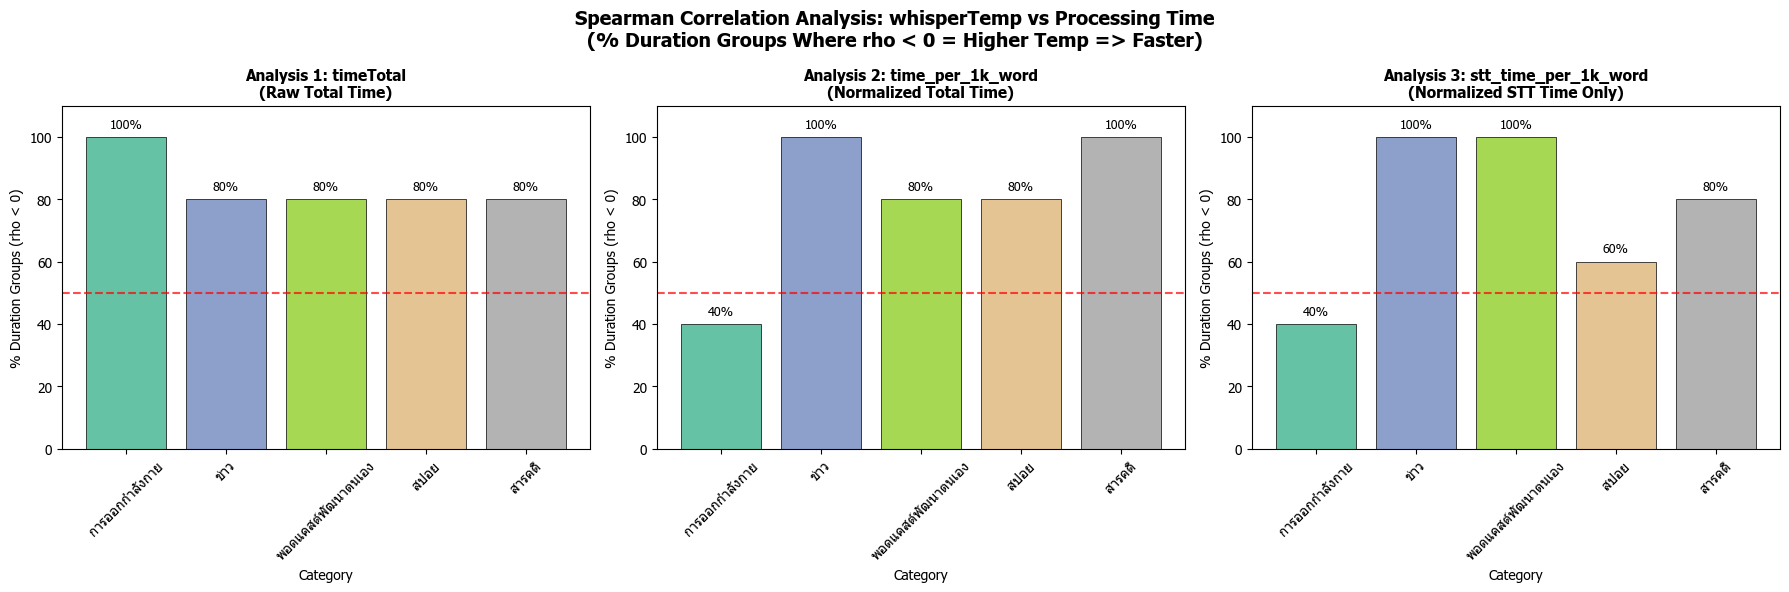

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import re
import warnings
warnings.filterwarnings('ignore')

# Configure Thai font support
plt.rcParams['font.family'] = 'Tahoma'

# --- Load Data ---
stats_df = pd.read_csv('stats_data.csv')
mapper_df = pd.read_excel('75clip_mapper.xlsx')

userId = 6

# --- Filter userId = 6 and status = DONE ---
df_user6 = stats_df[(stats_df['userId'] == userId) & (stats_df['status'] == 'DONE')].copy()

# --- Normalize YouTube URL for joining ---
def normalize_url(url):
    if pd.isna(url):
        return None
    patterns = [
        r'(?:v=|youtu\.be/)([a-zA-Z0-9_-]{11})',
        r'(?:embed/)([a-zA-Z0-9_-]{11})',
        r'(?:shorts/)([a-zA-Z0-9_-]{11})'
    ]
    for pattern in patterns:
        match = re.search(pattern, str(url))
        if match:
            return match.group(1)
    return None

df_user6['video_id'] = df_user6['youtubeUrl'].apply(normalize_url)
mapper_df['video_id'] = mapper_df['YoutubeUrl'].apply(normalize_url)

# --- Merge with mapper ---
df_merged = df_user6.merge(
    mapper_df[['video_id', 'Category', 'Duration(min)']],
    on='video_id',
    how='left'
)

# --- Filter valid data ---
df_merged = df_merged.dropna(subset=['transcriptWord', 'durationSec', 'timeTotal', 'Category'])

print(f'Total clips for userId=6: {len(df_merged)}')
print(f'Categories: {df_merged["Category"].unique()}')

# Prepare the data
df = df_merged.copy()
df["duration_group"] = (df["durationSec"] / 300).round().astype(int) * 300
df["time_per_1k_word"] = df["timeTotal"] / df["transcriptWord"] * 1000
df["stt_time_per_1k_word"] = df["timeSpeechtoTextSec"] / df["transcriptWord"] * 1000

# Analysis 1: timeTotal vs whisperTemp
results_1 = []
for (cat, dur), g in df.groupby(["Category", "duration_group"]):
    if g["whisperTemp"].nunique() >= 3:
        rho, _ = spearmanr(g["whisperTemp"], g["timeTotal"])
        results_1.append({"Category": cat, "Duration": dur, "rho": rho})
rho_df_1 = pd.DataFrame(results_1)
summary_1 = rho_df_1.assign(is_faster=lambda x: x["rho"] < 0).groupby("Category")["is_faster"].mean()

# Analysis 2: time_per_1k_word vs whisperTemp
results_2 = []
for (cat, dur), g in df.groupby(["Category", "duration_group"]):
    if g["whisperTemp"].nunique() >= 3:
        rho, _ = spearmanr(g["whisperTemp"], g["time_per_1k_word"])
        results_2.append({"Category": cat, "Duration": dur, "rho_norm": rho})
rho_df_2 = pd.DataFrame(results_2)
summary_2 = rho_df_2.assign(is_faster=lambda x: x["rho_norm"] < 0).groupby("Category")["is_faster"].mean()

# Analysis 3: stt_time_per_1k_word vs whisperTemp
results_3 = []
for (cat, dur), g in df.groupby(["Category", "duration_group"]):
    if g["whisperTemp"].nunique() >= 3:
        rho, _ = spearmanr(g["whisperTemp"], g["stt_time_per_1k_word"])
        results_3.append({"Category": cat, "Duration": dur, "rho_norm": rho})
rho_df_3 = pd.DataFrame(results_3)
summary_3 = rho_df_3.assign(is_faster=lambda x: x["rho_norm"] < 0).groupby("Category")["is_faster"].mean()

# Create visualization 1: Bar Chart Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Spearman Correlation Analysis: whisperTemp vs Processing Time\n(% Duration Groups Where rho < 0 = Higher Temp => Faster)', fontsize=14, fontweight='bold')

# Define colors for each category
categories = summary_1.index.tolist()
colors = plt.cm.Set2(np.linspace(0, 1, len(categories)))
color_map = {cat: colors[i] for i, cat in enumerate(categories)}

# Plot 1: timeTotal
ax1 = axes[0]
bars1 = ax1.bar(summary_1.index, summary_1.values * 100, 
                color=[color_map[cat] for cat in summary_1.index],
                edgecolor='black', linewidth=0.5)
ax1.set_ylabel('% Duration Groups (rho < 0)', fontsize=10)
ax1.set_xlabel('Category', fontsize=10)
ax1.set_title('Analysis 1: timeTotal\n(Raw Total Time)', fontsize=11, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 110)
ax1.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
for bar, val in zip(bars1, summary_1.values * 100):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{val:.0f}%', ha='center', va='bottom', fontsize=9)

# Plot 2: time_per_1k_word
ax2 = axes[1]
bars2 = ax2.bar(summary_2.index, summary_2.values * 100,
                color=[color_map[cat] for cat in summary_2.index],
                edgecolor='black', linewidth=0.5)
ax2.set_ylabel('% Duration Groups (rho < 0)', fontsize=10)
ax2.set_xlabel('Category', fontsize=10)
ax2.set_title('Analysis 2: time_per_1k_word\n(Normalized Total Time)', fontsize=11, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0, 110)
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
for bar, val in zip(bars2, summary_2.values * 100):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}%', ha='center', va='bottom', fontsize=9)

# Plot 3: stt_time_per_1k_word
ax3 = axes[2]
bars3 = ax3.bar(summary_3.index, summary_3.values * 100,
                color=[color_map[cat] for cat in summary_3.index],
                edgecolor='black', linewidth=0.5)
ax3.set_ylabel('% Duration Groups (rho < 0)', fontsize=10)
ax3.set_xlabel('Category', fontsize=10)
ax3.set_title('Analysis 3: stt_time_per_1k_word\n(Normalized STT Time Only)', fontsize=11, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylim(0, 110)
ax3.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
for bar, val in zip(bars3, summary_3.values * 100):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('spearman_analysis_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Speech-to-Text  เป็น bottleneck จริงไหม Speech-to-Text ใช้สัดส่วนกี่ % ของ total time ในแต่ละ Category?

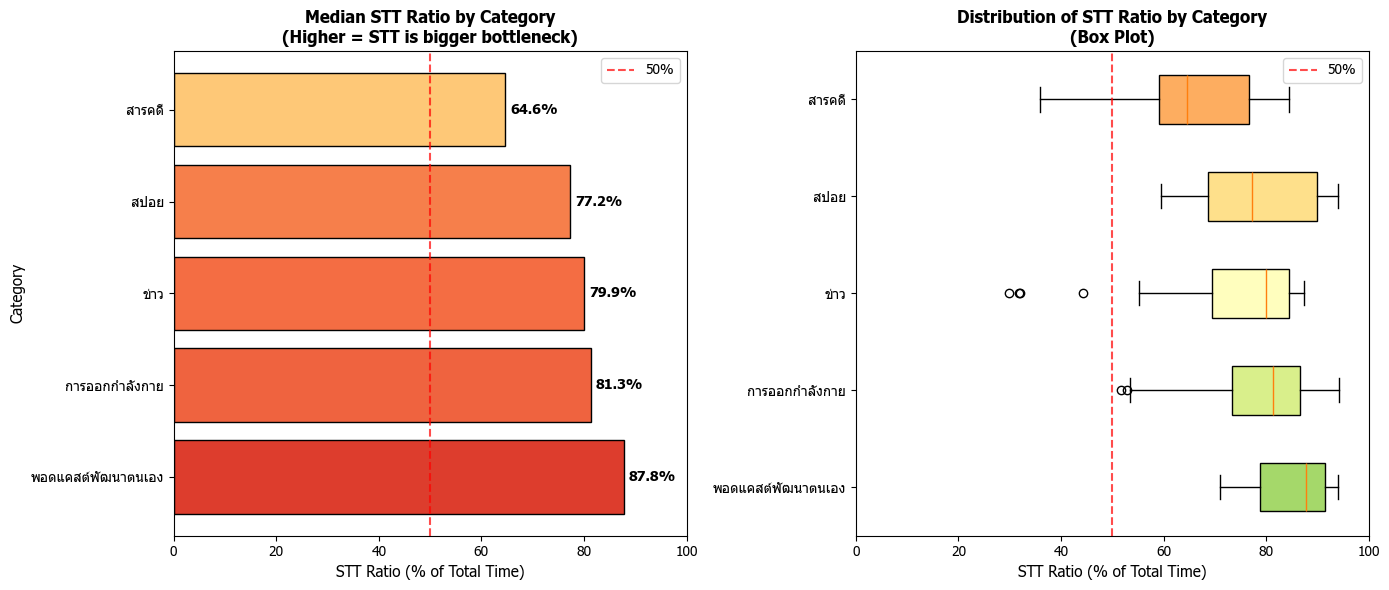

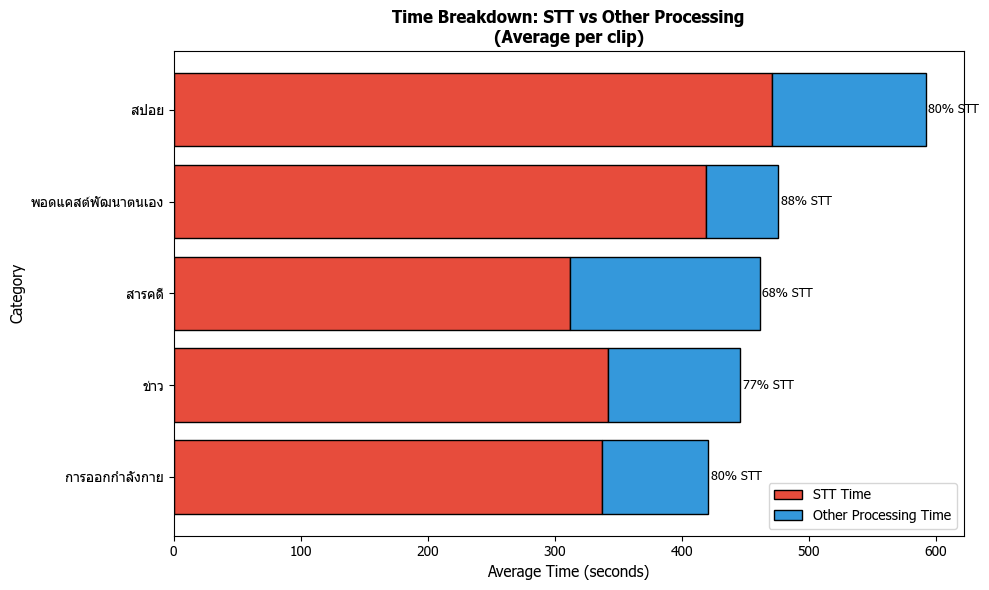


📊 STT Bottleneck Analysis Summary

Category                  Median %     Mean %       Count
-------------------------------------------------------
พอดแคสต์พัฒนาตนเอง            87.8%        85.5%       60
การออกกำลังกาย                81.3%        78.6%       61
ข่าว                          79.9%        74.8%       57
สปอย                          77.2%        78.3%       63
สารคดี                        64.6%        65.3%       56
-------------------------------------------------------
Overall                       78.9%

💡 Conclusion:
   STT คิดเป็น 78.9% ของเวลาทั้งหมด → STT เป็น bottleneck หลัก ✅


In [2]:
# ===========================================
# STT Bottleneck Analysis: สัดส่วนเวลา STT ต่อ Total Time
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# กำหนดฟอนต์ภาษาไทย
plt.rcParams['font.family'] = 'Tahoma'

# คำนวณ stt_ratio
df["stt_ratio"] = df["timeSpeechtoTextSec"] / df["timeTotal"]

# วิเคราะห์ตาม Category
stt_stats = df.groupby("Category")["stt_ratio"].agg(['median', 'mean', 'std', 'count'])
stt_stats = stt_stats.sort_values('median', ascending=False)

# ===========================================
# Visualization 1: Bar Chart - Median STT Ratio by Category
# ===========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Median STT Ratio
ax1 = axes[0]
colors = plt.cm.RdYlGn_r(stt_stats['median'].values)  # สีแดง = สัดส่วนสูง
bars = ax1.barh(stt_stats.index, stt_stats['median'] * 100, color=colors, edgecolor='black')
ax1.set_xlabel('STT Ratio (% of Total Time)', fontsize=11)
ax1.set_ylabel('Category', fontsize=11)
ax1.set_title('Median STT Ratio by Category\n(Higher = STT is bigger bottleneck)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 100)
ax1.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='50%')

# เพิ่มตัวเลขบน bar
for bar, val in zip(bars, stt_stats['median'] * 100):
    ax1.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
             va='center', fontsize=10, fontweight='bold')

ax1.legend()

# ===========================================
# Visualization 2: Box Plot - Distribution of STT Ratio
# ===========================================
ax2 = axes[1]
categories_sorted = stt_stats.index.tolist()
data_for_boxplot = [df[df['Category'] == cat]['stt_ratio'].values * 100 for cat in categories_sorted]

bp = ax2.boxplot(data_for_boxplot, vert=False, patch_artist=True)
ax2.set_yticklabels(categories_sorted)
ax2.set_xlabel('STT Ratio (% of Total Time)', fontsize=11)
ax2.set_title('Distribution of STT Ratio by Category\n(Box Plot)', fontsize=12, fontweight='bold')
ax2.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='50%')
ax2.set_xlim(0, 100)

# สีของ box plot
colors_bp = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(categories_sorted)))
for patch, color in zip(bp['boxes'], colors_bp):
    patch.set_facecolor(color)

ax2.legend()

plt.tight_layout()
plt.savefig('stt_bottleneck_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# ===========================================
# Visualization 3: Stacked Bar - เวลา STT vs เวลาอื่นๆ
# ===========================================
fig2, ax3 = plt.subplots(figsize=(10, 6))

# คำนวณค่าเฉลี่ยเวลาสำหรับแต่ละ Category
time_breakdown = df.groupby("Category").agg({
    'timeSpeechtoTextSec': 'mean',
    'timeTotal': 'mean'
}).sort_values('timeTotal', ascending=True)

time_breakdown['other_time'] = time_breakdown['timeTotal'] - time_breakdown['timeSpeechtoTextSec']

# Stacked Bar
bars_stt = ax3.barh(time_breakdown.index, time_breakdown['timeSpeechtoTextSec'], 
                     label='STT Time', color='#e74c3c', edgecolor='black')
bars_other = ax3.barh(time_breakdown.index, time_breakdown['other_time'], 
                       left=time_breakdown['timeSpeechtoTextSec'],
                       label='Other Processing Time', color='#3498db', edgecolor='black')

ax3.set_xlabel('Average Time (seconds)', fontsize=11)
ax3.set_ylabel('Category', fontsize=11)
ax3.set_title('Time Breakdown: STT vs Other Processing\n(Average per clip)', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right')

# เพิ่ม % บน bar
for i, cat in enumerate(time_breakdown.index):
    stt_time = time_breakdown.loc[cat, 'timeSpeechtoTextSec']
    total_time = time_breakdown.loc[cat, 'timeTotal']
    ratio = stt_time / total_time * 100
    ax3.text(total_time + 2, i, f'{ratio:.0f}% STT', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('stt_time_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()

# ===========================================
# Print Summary
# ===========================================
print("\n" + "=" * 50)
print("📊 STT Bottleneck Analysis Summary")
print("=" * 50)
print(f"\n{'Category':<25} {'Median %':<12} {'Mean %':<12} {'Count'}")
print("-" * 55)
for cat in stt_stats.index:
    print(f"{cat:<25} {stt_stats.loc[cat, 'median']*100:>8.1f}%    {stt_stats.loc[cat, 'mean']*100:>8.1f}%    {int(stt_stats.loc[cat, 'count']):>5}")

overall_median = df['stt_ratio'].median() * 100
print("-" * 55)
print(f"{'Overall':<25} {overall_median:>8.1f}%")
print("\n💡 Conclusion:")
if overall_median > 50:
    print(f"   STT คิดเป็น {overall_median:.1f}% ของเวลาทั้งหมด → STT เป็น bottleneck หลัก ✅")
else:
    print(f"   STT คิดเป็น {overall_median:.1f}% ของเวลาทั้งหมด → STT ไม่ใช่ bottleneck หลัก")

## temp สูง ทำให้เวลา “ผันผวน” มากขึ้นไหม

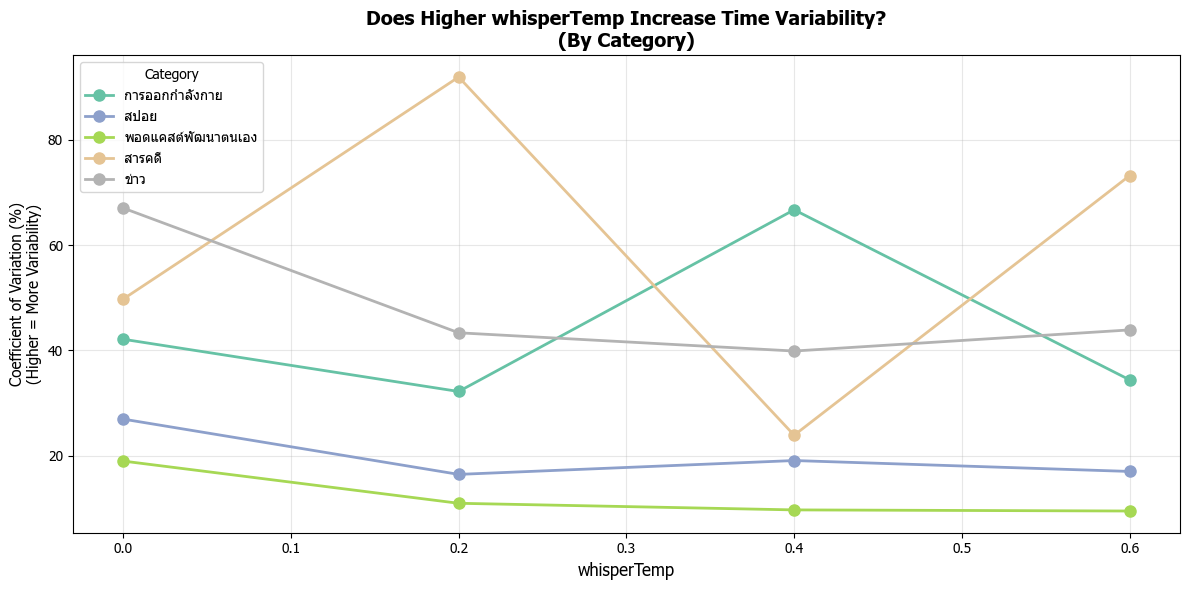


📊 Spearman: whisperTemp vs CV (แยกตาม Category)

Category                  rho        p-value    Result
-----------------------------------------------------------------
การออกกำลังกาย            +0.000     1.0000     ไม่มีผลชัด
สปอย                      -0.400     0.6000     ↑temp = ↓ผันผวน ✅
พอดแคสต์พัฒนาตนเอง        -1.000     0.0000     ↑temp = ↓ผันผวน ✅
สารคดี                    +0.000     1.0000     ไม่มีผลชัด
ข่าว                      -0.400     0.6000     ↑temp = ↓ผันผวน ✅


: 

In [ ]:
# ===========================================
# whisperTemp vs Variability แยกตาม Category
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

plt.rcParams['font.family'] = 'Tahoma'

df_clean = df[df['transcriptWord'] >= 100]

# คำนวณ CV สำหรับแต่ละ (Category, whisperTemp)
variability = df_clean.groupby(["Category", "whisperTemp"])["time_per_1k_word"].agg(['mean', 'std', 'count'])
variability['cv'] = variability['std'] / variability['mean'] * 100
variability = variability.reset_index()

# ===========================================
# Visualization: Line Plot แยกตาม Category
# ===========================================
fig, ax = plt.subplots(figsize=(12, 6))

categories = df_clean['Category'].unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(categories)))

for i, cat in enumerate(categories):
    cat_data = variability[variability['Category'] == cat]
    ax.plot(cat_data['whisperTemp'], cat_data['cv'], 
            marker='o', linewidth=2, markersize=8,
            label=cat, color=colors[i])

ax.set_xlabel('whisperTemp', fontsize=12)
ax.set_ylabel('Coefficient of Variation (%)\n(Higher = More Variability)', fontsize=11)
ax.set_title('Does Higher whisperTemp Increase Time Variability?\n(By Category)', fontsize=14, fontweight='bold')
ax.legend(title='Category', loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('whisper_temp_variability_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

# ===========================================
# สรุป Spearman Correlation แยกตาม Category
# ===========================================
print("\n" + "=" * 60)
print("📊 Spearman: whisperTemp vs CV (แยกตาม Category)")
print("=" * 60)
print(f"\n{'Category':<25} {'rho':<10} {'p-value':<10} {'Result'}")
print("-" * 65)

for cat in categories:
    cat_data = variability[variability['Category'] == cat]
    if len(cat_data) >= 3:
        rho, p = spearmanr(cat_data['whisperTemp'], cat_data['cv'])
        if rho > 0.3:
            result = "↑temp = ↑ผันผวน ⚠️"
        elif rho < -0.3:
            result = "↑temp = ↓ผันผวน ✅"
        else:
            result = "ไม่มีผลชัด"
        print(f"{cat:<25} {rho:>+.3f}     {p:<10.4f} {result}")